# How to deal with Vanishing and Exploding gradients in DNNs.

## Unstable gradients

- Deep NNs often suffers from the unstable gradients as we move from upper to lower layer through backpropogation. 
- Most common issue being the issue of vanishing gradients where the gradient keep on vanishing as we move lower through the layers. This lead to the weights standing still.
- There is also problem of exploding gradient as we backpropogate, mainly in the so called recurrent neural networks (DNNs which are initialized from an already existing ANN). In this case, out deepest descent diverges.


### What causes vanishing gradients?

- Saturating activation function like sigmoid function .
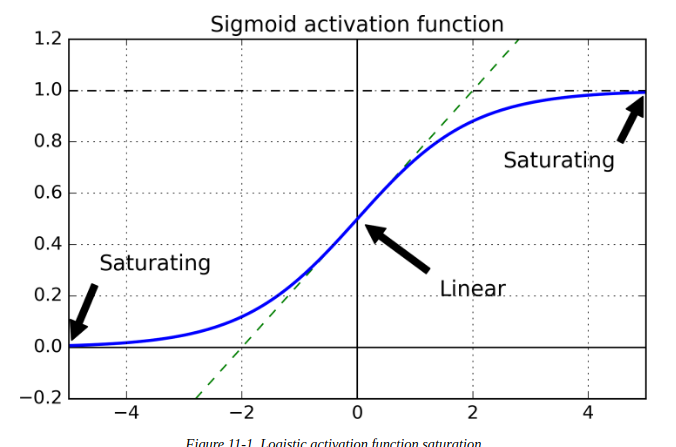
- Initiliaztion of weights where the mean is non zero and variacne of each input  with respect to all the instance is different to the variance of the output. 


## Methods to fix the unstable gradients

### 1. Using a different weight initialization strategy.

- Inorder to have stable gradients, we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. 
- To attain something close to this, the connection weights of each layer must be initialized randomly as 
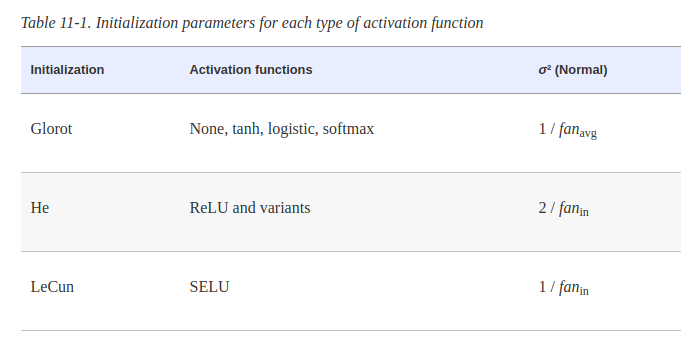
where fanavg = (fanin + fanout)/2.


#### Implementing different initialization in Keras

We simple need to pass the initialization argument into the keras.layers.Dense() object.
```
    keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

```
You can also use special initializations with uniform distribution function as follows:

```
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                                 distribution='uniform')
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)

```
    


### 2. Using a Nonsaturating Activation function

- __ReLu__ function is one of the most popular activation function. NOte that $ReLu(x) = \max(x,0)$. This coud replace the traditional sigmoid or tanh function since it doesn't saturate like the latter functions. 
- Problem of dying ReLu function: A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.
#### Use variants of ReLu function to prevent neurons from dying.
- __Leaky ReLu__: This function is defined as $LeakyReLUα(z) = \max(αz, z)$ . The hyperparameter α defines how much the function “leaks”: it is the slope of the function for z < 0 and is typically set to 0.01. This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up. 
-  __Parametric leaky ReLU (PReLU)__, where α is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter). PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.
- 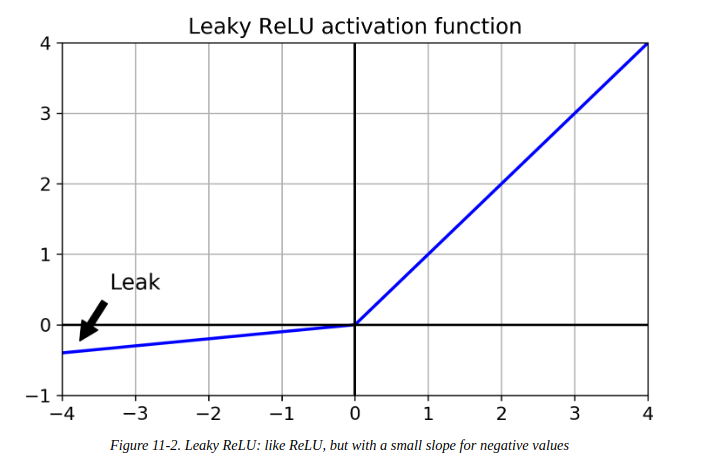

- __exponential linear unit (ELU)__,   
$ ELUα(z)=α(exp(z)−1)z \ if \ z<0 $  
$ ELUα(z)=z \ if z\ge0 $  
that outperformed all the ReLU variants in the authors’ experiments: training time was reduced, and the neural network performed better on the test set. 
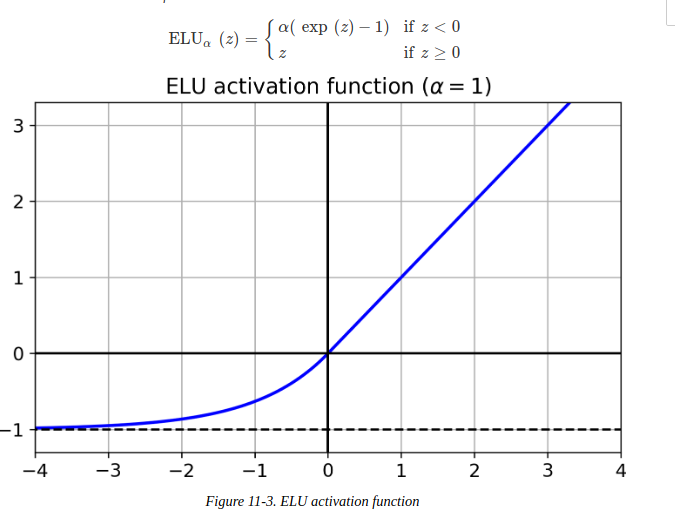


- Note that ELU is slower to compute because of the exponential function involved compated to ReLu.
- Another popular approach is to use __Scaled ELU (SELU)__

- 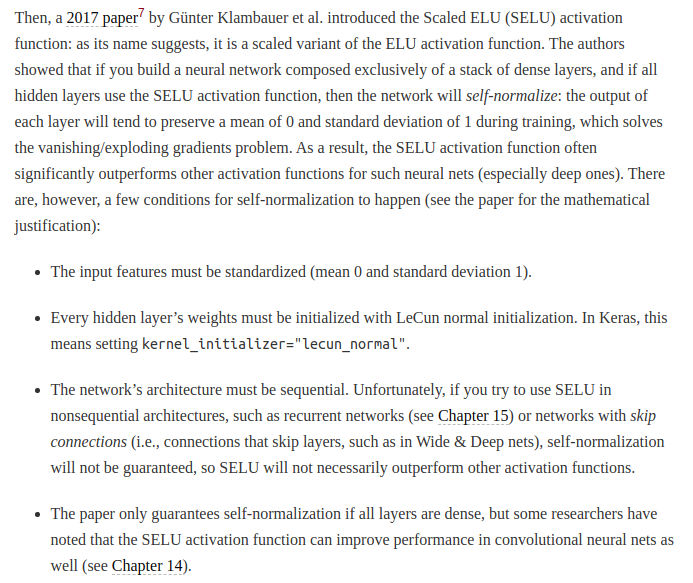

#### Implemting different activation function in Keras
To use a different activation like LeakyRLU in Keras, simply skip adding an activation function to the keras.layers.Dense() object and simple add a layer for leaky activation function after the dense layer.
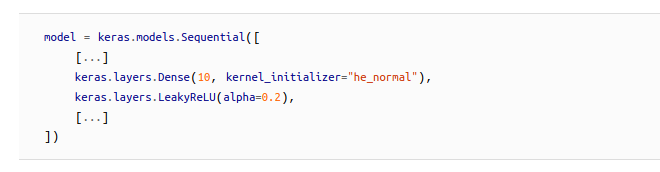

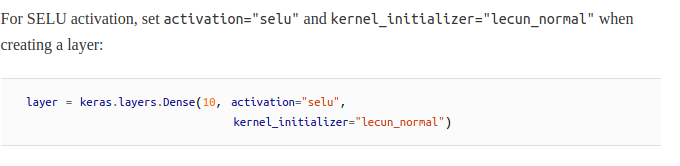

### 3.Batch normalization 

- __BN__: Very affect in stabilizing the gradient.  
- The technique consists of adding an operation in the model just before or after the activation function of each hidden layer.   
- This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a StandardScaler); the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).  
- 

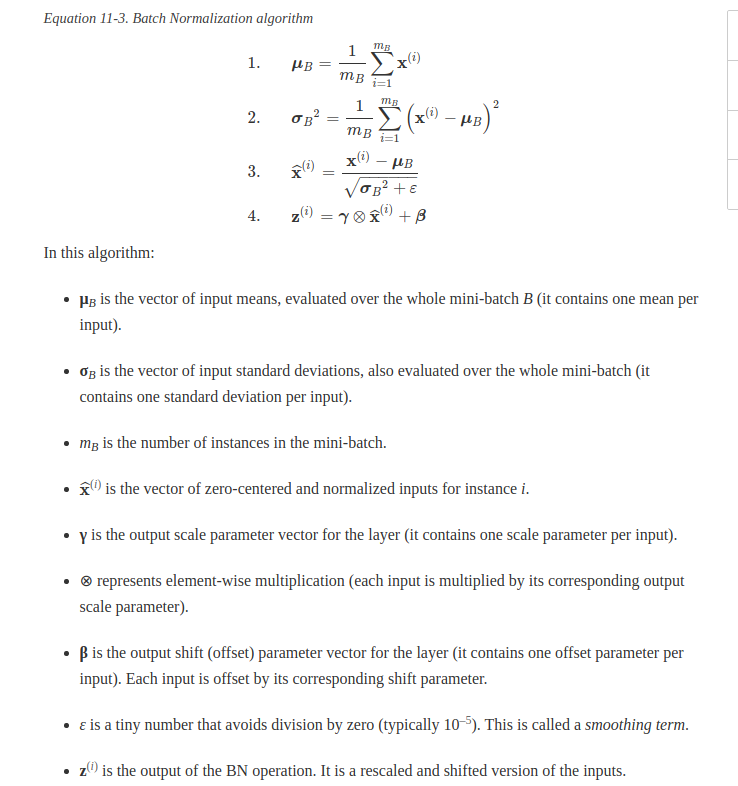

- Summary of algorithm :  four parameter vectors are learned in each batch-normalized layer: γ (the output scale vector) and β (the output offset vector) are learned through regular backpropagation, and μ (the final input mean vector) and σ (the final input standard deviation vector) are estimated using an exponential moving average. Note that μ and σ are estimated during training, but they are used only after training (to replace the batch input means and standard deviations in Equation 11-3).

#### Implementing BN in Keras

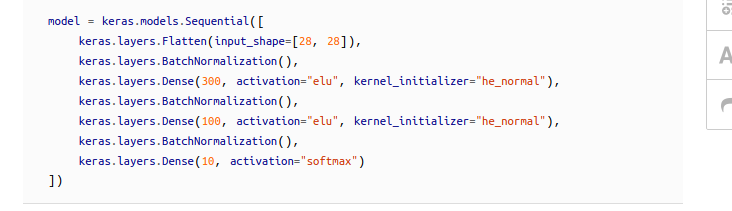

In [11]:
import tensorflow as tf
from tensorflow import keras
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 784)               3136      
_________________________________________________________________
dense_9 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_10 (Batc (None, 300)               1200      
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
batch_normalization_11 (Batc (None, 100)               400       
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

Let’s look at the parameters of the first BN layer. Two are trainable (by backpropagation), and two are not:

In [15]:
for var in model.layers[1].variables:
    print(var.name, " - ",var.trainable)

batch_normalization_9/gamma:0  -  True
batch_normalization_9/beta:0  -  True
batch_normalization_9/moving_mean:0  -  False
batch_normalization_9/moving_variance:0  -  False


__We can remove the bias from every layer of the network for which we are using batch normalization since we already have an offset $\beta$ as the parameter in the batch normalization layer.__

In [16]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])

## 4. Gradient clipping.
- This technique is mainly used to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold.
- Implementation in keras:  
```optimizer = keras.optimizers.SGD(clipvalue=1.0)
   model.compile(loss="mse", optimizer=optimizer)   
```
- We can also clip the gradient using the l2 norm of the gradient so the directin of the gradient remains the same even after clipping. 
```optimizer = keras.optimizers.SGD(clipnorm=1.0)
   model.compile(loss="mse", optimizer=optimizer)   
```
    